# Lab7: Trajectory Generation



In this lab, we will learn how to generate optimal trajectories for dynamic systems using numerical optimization. The lab is organized into several tasks:

- **Task 1:** Generate optimal trajectories for a double integrator system using both a convex optimization library (CVXPY) and the Python control library. Compare the results and explore how changing parameters affects the solution.
- **Task 2:** Formulate and solve optimal control problems for a kinematic car model. Investigate different cost functions, input and terminal constraints, and analyze how these choices influence the resulting trajectories.


Throughout the lab, you will experiment with problem setup, solver options, and initial guesses to understand their impact on optimal control solutions.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time
try:
  import cvxpy as cp
  print("cvxpy", cp.__version__)
except ImportError:
  !pip install cvxpy
try:
  import control as ctl
  print("python-control", ctl.__version__)
except ImportError:
  !pip install control
  import control as ctl
import control.optimal as opt

cvxpy 1.6.7
python-control 0.10.2


## Task 1: Double Integrator Optimal Trajectory Generation

In this task, we try to generate optimal trajectories by reformulating the problme into a numerical optimization problem. We will use two approaches. The first approach will directly use an optimization libarary, while the second will use the Python control libarary.

### Approach 1: Using Convex Optimization Libarary

We first use the CVXPY library to solve the optimization problem. CVXPY is an open-source Python-embedded modeling language for convex optimization problems, allowing users to specify and solve a wide range of convex programs easily. For more information, see the [CVXPY documentation](https://www.cvxpy.org/).

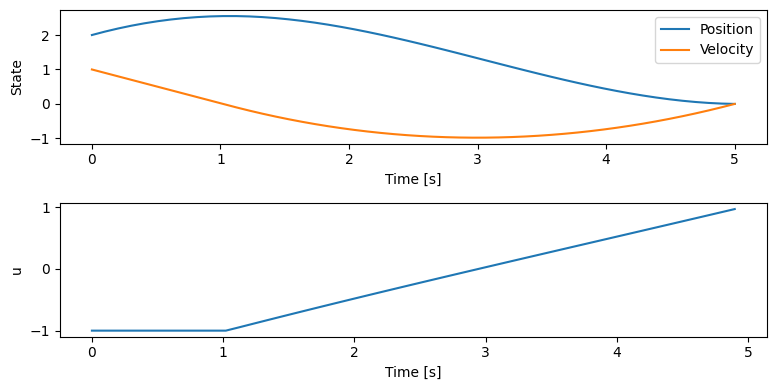

In [23]:
Tf = 5  # final time
dt = 0.1  # time step
timepts = np.linspace(0, Tf, int(Tf/dt), endpoint=True)
N = len(timepts)  # number of time steps
A = np.eye(2) + dt * np.array([[0, 1], [0, 0]])
B = dt * np.array([[0], [1]])

x = cp.Variable((2, N))  # decision variable: states [position; velocity]
u = cp.Variable((1, N-1))  # decision variable: control input [acceleration]

constraints = [x[:, 0] == [2, 1]]  # initial condition, x[:, 0] is the first column of x, i.e., x at time 0
# dynamics and input constraints: "+=" means append to the list
for n in range(N-1):
    constraints += [x[:, n+1] == A @ x[:, n] + B @ u[:, n]]  # dynamics constraint
    constraints += [cp.abs(u[:, n]) <= 1]  # input constraint
# The final state is at index N-1 because of 0-based indexing (indices are 0, 1, ..., N-1)
constraints += [x[:, N-1] == [0, 0]]  # final condition

# objective: minimize control effort
#cost = cp.sum_squares(u)
cost = 100*cp.sum_squares(u) + 1*cp.sum_squares(x) # alternative cost with state penalty
# formulate and solve the problem
prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve()

x_sol = x.value  # optimal state trajectory
u_sol = u.value  # optimal control inputs

# Plot the results
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.plot(timepts, x_sol[0, :], label='Position')
plt.plot(timepts, x_sol[1, :], label='Velocity')
plt.xlabel('Time [s]')
plt.ylabel('State')
plt.legend()

plt.subplot(2,1,2)
plt.plot(timepts[:-1], u_sol[0, :], label='Control input')
plt.xlabel('Time [s]')
plt.ylabel('u')
plt.tight_layout()
plt.show()

Try to play with the following to see what will happen:
- change the value of `Tf`
- change the time step `dt`
- change the initial condition `x[:, 0]`

### Approach 2: Using Python Control Libarary


We will then generate the trajectory directly using Python control Libarary. The main function used in this approach is `solve_ocp`, which solves the optimal control problem for a given system. See the [python-control optimal control documentation](https://python-control.readthedocs.io/en/latest/optimal.html#python-control.optimal.solve_ocp) for a detailed description of this function.

The required and optional input parameters are:

- **Required:**
    - `system`: The system to optimize (e.g., state-space or nonlinear system).
    - `timepts`: Array of time points for discretization.
    - `x0`: Initial state.
    - `cost`: Cost function to minimize (e.g., quadratic cost).

- **Optional:**
    - `constraints`: List of trajectory/input constraints (e.g., input limits).
    - `terminal_constraints`: List of constraints on the final state.
    - `terminal_cost`: Additional cost on the final state.
    - `initial_guess`: Initial guess for state and input trajectories.
    - `minimize_method`: Optimization solver to use (e.g., `'SLSQP'`, `'trust-constr'`).
    - `minimize_options`: Dictionary of options for the solver.
    - `trajectory_method`, `solve_ivp_method`, `solve_ivp_kwargs`: Advanced options for trajectory integration and solver configuration.

This function returns an object containing the optimal state and input trajectories, which can be plotted and analyzed.

Summary statistics:
* Cost function calls: 2115
* Constraint calls: 2281
* Eqconst calls: 2281
* System simulations: 1
* Final cost: 2.1748591647687445


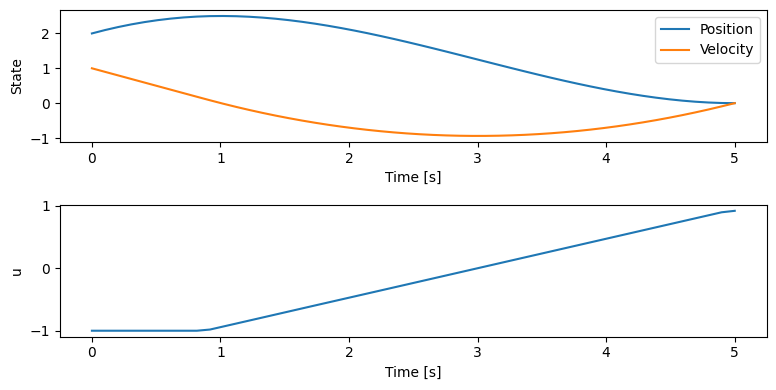

In [25]:
# Set up the cost functions for the double integrator
Qx = np.diag([0, 0])  # penalize position and velocity error
Qu = np.array([[1]])  # penalize control effort

# Define initial and final states
x0_di = np.array([2, 1])
xf_di = np.array([0, 0])
uf_di = np.array([0])   # desired final input

# Create a state-space system for the double integrator
A_di = np.array([[0, 1], [0, 0]])
B_di = np.array([[0], [1]])
C_di = np.eye(2)  # output both position and velocity
D_di = np.zeros((2,1)) # no direct feedthrough
sys_di = ctl.ss(A_di, B_di, C_di, D_di)

# Quadratic cost function
quad_cost_di = opt.quadratic_cost(sys_di, Qx, Qu, x0=xf_di, u0=uf_di)

#add constraints for the control input
u_min = np.array([-1])
u_max = np.array([1])
constraints = [ opt.input_range_constraint(sys_di, u_min, u_max) ] # input limits
# Define lower and upper bounds for the final state
xf_lb = np.array([0, 0])  # lower bound for final state
xf_up = np.array([0, 0])  # upper bound for final state
# The terminal constraint enforces that the final state must be exactly [0, 0]
terminal = [ opt.state_range_constraint(sys_di, xf_lb, xf_up) ]

# Solve the optimal control problem
result_di = opt.solve_ocp(
    sys_di, timepts, x0_di, quad_cost_di,
    constraints=constraints,
    terminal_constraints=terminal,
    # initial_guess=initial_guess_di,
    # minimize_method='SLSQP',
    # minimize_options={'ftol': 1e-4, 'eps': 0.01}
)

# Plot the results
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.plot(result_di.time, result_di.states[0], label='Position')
plt.plot(result_di.time, result_di.states[1], label='Velocity')
plt.xlabel('Time [s]')
plt.ylabel('State')
plt.legend()

plt.subplot(2,1,2)
plt.plot(result_di.time, result_di.inputs[0], label='Control input')
plt.xlabel('Time [s]')
plt.ylabel('u')
plt.tight_layout()
plt.show()

Compare the results generate by the two approaches. Are they the same?

## Task 2: Kinematic Car: Optimal trajectory generation


### Vehicle steering dynamics

<img src="https://fbswiki.org/wiki/images/5/52/Kincar.png" width=480>

The vehicle dynamics are given by a simple bicycle model.  We take the state of the system as $(x, y, \theta)$ where $(x, y)$ is the position of the vehicle in the plane and $\theta$ is the angle of the vehicle with respect to horizontal.  The vehicle input is given by $(v, \delta)$ where $v$ is the forward velocity of the vehicle and $\delta$ is the angle of the steering wheel.  The model includes saturation of the vehicle steering angle.

$$\begin{aligned}
  \dot x &= \cos\theta\, v \\
  \dot y &= \sin\theta\, v \\
  \dot\theta &= \frac{v}{l} \tan \delta
\end{aligned}$$

In [26]:
# Code to model vehicle steering dynamics

# Function to compute the RHS of the system dynamics
def kincar_update(t, x, u, params):
    # Get the parameters for the model
    l = params['wheelbase']             # vehicle wheelbase
    deltamax = params['maxsteer']         # max steering angle (rad)

    # Saturate the steering input
    delta = np.clip(u[1], -deltamax, deltamax)

    # Return the derivative of the state
    return np.array([
        np.cos(x[2]) * u[0],            # xdot = cos(theta) v
        np.sin(x[2]) * u[0],            # ydot = sin(theta) v
        (u[0] / l) * np.tan(delta)      # thdot = v/l tan(delta)
    ])

kincar_params={'wheelbase': 3, 'maxsteer': 0.5}

# Create nonlinear input/output system
kincar = ctl.nlsys(
    kincar_update, None, name="kincar", params=kincar_params,
    inputs=('v', 'delta'), outputs=('x', 'y', 'theta'),
    states=('x', 'y', 'theta'))

In [27]:
# Utility function to plot lane change manuever
def plot_lanechange(t, y, u, figure=None, yf=None, label=None):
    # Plot the xy trajectory
    plt.subplot(3, 1, 1, label='xy')
    plt.plot(y[0], y[1], label=label)
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    if yf is not None:
        plt.plot(yf[0], yf[1], 'ro')

    # Plot x and y as functions of time
    plt.subplot(3, 2, 3, label='x')
    plt.plot(t, y[0])
    plt.ylabel("$x$ [m]")

    plt.subplot(3, 2, 4, label='y')
    plt.plot(t, y[1])
    plt.ylabel("$y$ [m]")

    # Plot the inputs as a function of time
    plt.subplot(3, 2, 5, label='v')
    plt.plot(t, u[0])
    plt.xlabel("Time $t$ [sec]")
    plt.ylabel("$v$ [m/s]")

    plt.subplot(3, 2, 6, label='delta')
    plt.plot(t, u[1])
    plt.xlabel("Time $t$ [sec]")
    plt.ylabel("$\\delta$ [rad]")

    plt.subplot(3, 1, 1)
    plt.title("Lane change manuever")
    if label:
        plt.legend()
    plt.tight_layout()

The general problem we are solving is of the form:

$$
\min_{u(\cdot)}
  \int_0^T L(x,u)\, dt + V \bigl( x(T) \bigr)
$$
subject to
$$
  \dot x = f(x, u), \qquad x\in \mathcal{X} \subset \mathbb{R}^n,\, u\in \mathcal{U} \subset \mathbb{R}^m
$$

We consider the problem of changing from one lane to another over a perod of 10 seconds while driving at a forward speed of 10 m/s.

In [31]:
# Initial and final conditions
x0 = np.array([  0., -2., 0.]); u0 = np.array([10., 0.])
xf = np.array([100.,  2., 0.]); uf = np.array([10., 0.])
Tf = 10.0  # total maneuver time

An important part of the optimization procedure is to give a good initial guess so that the algorithm can start from this guess to find the solution.  A good initial guess increases the likelihood that the optimizer will converge to a desirable solution and helps avoid getting stuck in a local minimum. Here are some possibilities:

In [30]:
# Define the time horizon (and spacing) for the optimization
# timepts = np.linspace(0, Tf, 5, endpoint=True)    # Try using this and see what happens
# timepts = np.linspace(0, Tf, 10, endpoint=True)   # Try using this and see what happens
timepts = np.linspace(0, Tf, 20, endpoint=True)

# Compute some initial guesses to use
# Note: bend_left only specifies the control inputs as an initial guess (not the states).
# The solver will have to compute the corresponding states that result from those inputs.
bend_left = [10, 0.01]          # slight left veer (will extend over all timepts)
straight_line = (               # straight line from start to end with nominal input
    np.array([x0 + (xf - x0) * t/Tf for t in timepts]).transpose(),
    u0
)

### Approach 1: standard quadratic cost

We can set up the optimal control problem as trying to minimize the distance from the desired final point while at the same time as not exerting too much control effort to achieve our goal.

$$
\min_{u(\cdot)}
  \int_0^T \left[(x(\tau) - x_\text{f})^T Q_x (x(\tau) - x_\text{f}) + (u(\tau) - u_\text{f})^T Q_u (u(\tau) - u_\text{f})\right] \, d\tau
$$
subject to
$$
  \dot x = f(x, u), \qquad x \in \mathbb{R}^n,\, u \in \mathbb{R}^m
$$

The optimization module in default mode is using direct shooting method to solve optimal control problems by choosing the values of the input at each point in the time horizon to try to minimize the cost:

$$
u_k(t_j) = \alpha_{k, j}, \qquad
u_k(t) = \frac{t_{j+1} - t}{h} \alpha_{k, j} + \frac{t - t_j}{h} \alpha_{{k},{j+1}}
$$

where $k$ is the index for control input (we have two inputs), $j$ is the index for disctetized time, $h$ is the time step. This equation is used because, in direct shooting methods for optimal control, the optimizer searches for the best input values at each discretized time point. The control input $u_k(t)$ is parameterized by a set of variables $\alpha_{k, j}$ at each time $t_j$, and between time points, the input is typically interpolated (here, linearly) to ensure a smooth trajectory. This approach converts the infinite-dimensional control problem into a finite-dimensional optimization over the parameters $\alpha_{k, j}$, making it tractable for numerical solvers. The finer the time discretization, the more parameters the optimizer has to adjust, allowing for more accurate and flexible control profiles.


Summary statistics:
* Cost function calls: 7609
* System simulations: 0
* Final cost: 1001.8795108989207
* Total time = 15.5927 seconds

Final computed state:  [1.09473493e+02 1.99994568e+00 3.51117208e-05]
Final simulated state: [1.05249839e+02 6.40836552e+00 3.06955844e-03]


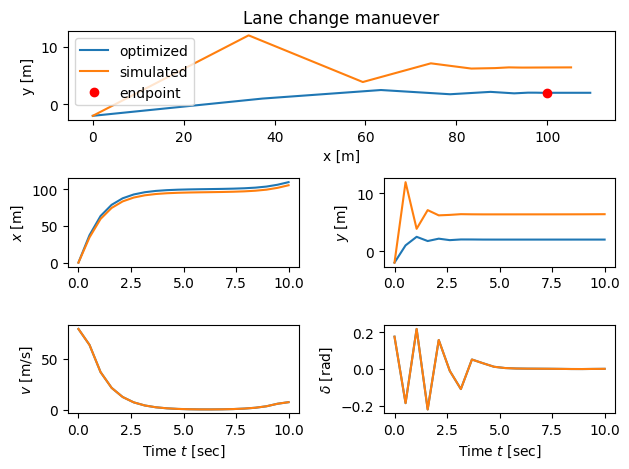

In [32]:
# Set up the cost functions
Qx = np.diag([.1, 10, .1])       # keep lateral error low
Qu = np.diag([.1, 1])            # minimize applied inputs
# Set desired final state and input for cost function (penalize deviation from these)
# Note: x0=xf and u0=uf here specify the "target" state and input for the cost function,
# not the initial condition. This means the optimizer penalizes deviation from the desired final state/input
# throughout the trajectory, even though the actual initial state is x0 (defined elsewhere).
quad_cost = opt.quadratic_cost(kincar, Qx, Qu, x0=xf, u0=uf)

# Compute the optimal control, setting step size for gradient calculation (eps)
start_time = time.process_time() # time how long the optimization takes
result1 = opt.solve_ocp(
    kincar, timepts, x0, quad_cost,
     initial_guess=straight_line,
    # initial_guess= bend_left,
    # initial_guess=u0,
    # minimize_method='trust-constr',
    # minimize_options={'finite_diff_rel_step': 0.01},
    # trajectory_method='shooting'
    # solve_ivp_method='LSODA'
)
print("* Total time = %5g seconds\n" % (time.process_time() - start_time))

# Plot the results from the optimization
plot_lanechange(timepts, result1.states, result1.inputs, xf)
print("Final computed state: ", result1.states[:,-1])

# Simulate the system using the optimal control inputs and see what happens
# Think about why doing this
t1, u1 = result1.time, result1.inputs
t1, y1 = ctl.input_output_response(kincar, timepts, u1, x0)
plot_lanechange(t1, y1, u1, yf=xf[0:2])
print("Final simulated state:", y1[:,-1])

# Label the different lines
plt.subplot(3, 1, 1)
plt.legend(['optimized', 'simulated', 'endpoint'])
plt.tight_layout()

Note the amount of time required to solve the problem and also any warning messages about to being able to solve the optimization (mainly in earlier versions of python-control).  You can try to adjust a number of factors to try to get a better solution:
* Try changing the number of points in the time horizon
* Try using a different initial guess
* Try changing the optimization method (see commented out code)

### Approach 2: input cost, input constraints, terminal cost

The previous solution integrates the position error for the entire horizon, and so the car changes lanes very quickly (at the cost of larger inputs).  Instead, we can penalize the final state and impose a higher cost on the inputs, resulting in a more gradual lane change. We can also limit the control input to be in a range $u_{\min} \le u(\tau) \le u_{\max}$, for any $\tau \in [0, T]$.

$$
\min_{u(\cdot)}
  \int_0^T \underbrace{\left[(u(\tau) - u_\text{f})^T Q_u (u(\tau) - u_\text{f})\right]}_{L(x, u)} \, d\tau + \underbrace{(x(T) - x_\text{f})^T Q_\text{f} (x(T) - x_\text{f})}_{V\left(x(T)\right)}
$$
subject to
$$
  \dot x = f(x, u), \qquad u_\text{lb} \leq u(t) \leq u_\text{ub} \qquad x \in \mathbb{R}^n,\, u \in \mathbb{R}^m
$$

We can also try using a different solver for this example.  You can pass the solver using the `minimize_method` keyword and send options to the solver using the `minimize_options` keyword (which should be set to a dictionary of options).

Summary statistics:
* Cost function calls: 4952
* Constraint calls: 5103
* System simulations: 0
* Final cost: 0.0002652249184370339
* Total time = 12.1223 seconds

Final computed state:  [9.99990914e+01 1.99998888e+00 2.58288064e-05]
Final simulated state: [ 9.99998025e+01  1.99655676e+00 -6.57601149e-04]


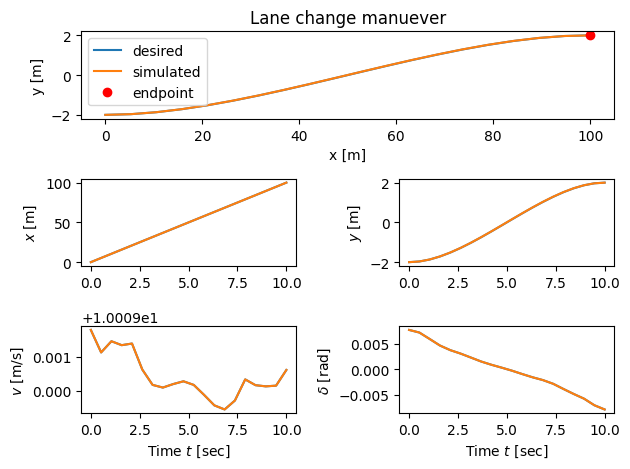

In [33]:
# Add input constraint, input cost, terminal cost
u_lb = np.array([8, -0.1])
u_ub = np.array([12, 0.1])
constraints = [ opt.input_range_constraint(kincar, u_lb, u_ub) ] # input limits
traj_cost = opt.quadratic_cost(kincar, None, np.diag([0.1, 1]), u0=uf)
term_cost = opt.quadratic_cost(kincar, np.diag([1, 10, 100]), None, x0=xf)

# Compute the optimal control
start_time = time.process_time()
result2 = opt.solve_ocp(
    kincar, timepts, x0, traj_cost, constraints, terminal_cost=term_cost,
    initial_guess=straight_line,
    # minimize_method='trust-constr',
    # minimize_options={'finite_diff_rel_step': 0.01},
    # minimize_method='SLSQP', minimize_options={'eps': 0.01},
    # log=True,
)
print("* Total time = %5g seconds\n" % (time.process_time() - start_time))

# Plot the results from the optimization
plot_lanechange(timepts, result2.states, result2.inputs, xf)
print("Final computed state: ", result2.states[:,-1])

# Simulate the system and see what happens
t2, u2 = result2.time, result2.inputs
t2, y2 = ctl.input_output_response(kincar, timepts, u2, x0)
plot_lanechange(t2, y2, u2, yf=xf[0:2])
print("Final simulated state:", y2[:,-1])

# Label the different lines
plt.subplot(3, 1, 1)
plt.legend(['desired', 'simulated', 'endpoint'], loc='upper left')
plt.tight_layout()

### Approach 3: Input cost, terminal constraints

We can also remove the cost function on the state and replace it with a terminal *constraint* on the state as well as bounds on the inputs.  If a solution is found, it guarantees we get to exactly the final state:

$$
\min_{u(\cdot)}
  \int_0^T \underbrace{(u(\tau) - u_\text{f})^T Q_u (u(\tau) - u_\text{f})}_{L(x, u)} \, d\tau
$$
subject to
$$
  \begin{aligned}
  \dot x &= f(x, u), & \qquad &x \in \mathbb{R}^n,\, u \in \mathbb{R}^m \\
  x(T) &= x_\text{f} & &u_\text{lb} \leq u(t) \leq u_\text{ub},\, \text{for all $t$}
  \end{aligned}
$$

Note that trajectory and terminal constraints can be very difficult to satisfy for a general optimization.

Summary statistics:
* Cost function calls: 3435
* Constraint calls: 3571
* Eqconst calls: 3571
* System simulations: 0
* Final cost: 0.0010138325733359827
* Total time = 5.89062 seconds

Final computed state:  [ 1.00000000e+02  2.00000000e+00 -8.78459974e-21]
Final state:  [ 1.00000284e+02  2.01110995e+00 -7.83324648e-04]


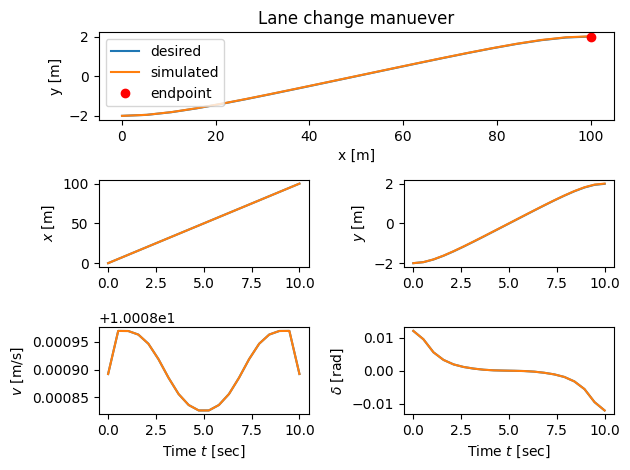

In [ ]:
# Input cost and terminal constraints
R = np.diag([1, 1])                 # minimize applied inputs
cost3 = opt.quadratic_cost(kincar, np.zeros((3,3)), R, u0=uf)
constraints = [
    opt.input_range_constraint(kincar, [8, -0.1], [12, 0.1]) ]
terminal = [ opt.state_range_constraint(kincar, xf, xf) ]

# Compute the optimal control
start_time = time.process_time()
result3 = opt.solve_ocp(
    kincar, timepts, x0, cost3, constraints,
    terminal_constraints=terminal, initial_guess=straight_line,
#    solve_ivp_kwargs={'atol': 1e-3, 'rtol': 1e-2},
#    minimize_method='trust-constr',
#    minimize_options={'finite_diff_rel_step': 0.01},
)
print("* Total time = %5g seconds\n" % (time.process_time() - start_time))

# Plot the results from the optimization
plot_lanechange(timepts, result3.states, result3.inputs, xf)
print("Final computed state: ", result3.states[:,-1])

# Simulate the system and see what happens
t3, u3 = result3.time, result3.inputs
t3, y3 = ctl.input_output_response(kincar, timepts, u3, x0)
plot_lanechange(t3, y3, u3, yf=xf[0:2])
print("Final simulated state:", y3[:,-1])

# Label the different lines
plt.subplot(3, 1, 1)
plt.legend(['desired', 'simulated', 'endpoint'], loc='upper left')
plt.tight_layout()

### Additional things to try

* Try using different weights, solvers, initial guess and other properties and see how things change.
* Try using different values for `initial_guess` to get faster convergence and/or different classes of solutions.

## HW Problem

### Problem 1: Trajectory Generation for Torque Limited Pendulum

In this problem, we will generate optimal trajectories for the pendulum with limited torque. For completeness, we include the dynamics equation here again:

$$
\begin{align}
\dot{x}_1 &= x_2 \\
\dot{x}_2 &= -\frac{g}{L}\sin x_1 - \frac{b}{mL^2}\,x_2 + \frac{u}{mL^2}
\end{align}
$$

where:
- $x_1 = \theta$ (pendulum angle)
- $x_2 = \dot{\theta}$ (angular velocity)
- $u$ = input torque (Nm)
- $g = 9.81\,\text{m/s}^2$ (gravity)
- $m = 1\,\text{kg}$ (mass)
- $L = 1\,\text{m}$ (length)
- $b = 1.5$ (N·m·s/rad, damping coefficient)

**Initial state:** $x_0 = [0,\, 0]$ (pendulum hanging down at rest)  
**Final state:** $x_f = [\pi,\, 0]$ (pendulum upright at rest)


#### Tasks

**1. Large Torque Limit ($|u| \leq 5$):**

Generate an optimal trajectory for the pendulum with input constraint $|u| \leq 5$ (corresponding to a strong motor). Use a time horizon of 5 seconds to start; increase it if the optimizer cannot reach the final state.

For each of the following cost functions, generate and plot the optimal trajectory:
- **(a) Input cost + terminal cost:**
   $$
   \min_{u(\cdot)} \int_0^T (u(\tau) - u_f)^T Q_u (u(\tau) - u_f)\, d\tau + (x(T) - x_f)^T Q_f (x(T) - x_f)
   $$
- **(b) Input cost with terminal constraint:**
   $$
   \min_{u(\cdot)} \int_0^T (u(\tau) - u_f)^T Q_u (u(\tau) - u_f)\, d\tau
   $$
   subject to $x(T) = x_f$

For each case, discuss:
- Are the results different? Why?
- Did you need to increase the time horizon to reach the final state?


**2. Small Torque Limit ($|u| \leq 0.5$):**

Repeat Task 1 with a smaller input constraint $|u| \leq 0.5$ (weaker motor).  
- Generate and plot the optimal trajectory for both cost functions above.
- Discuss how the reduced torque limit affects the ability to reach the final state and the required maneuver time.


**3. Velocity Constraint ($|x_2| \leq 0.3$ rad/s):**

Now, add a constraint on the angular velocity: $|x_2| \leq 0.3$ rad/s (e.g., for safety or actuator limits), with $|u| \leq 1$.

- Generate and plot the optimal trajectory for both cost functions above.
- If all other parameters (horizon, $Q_u$, $Q_f$, etc.) are the same as in Task 1, how do the results change compared to Task 1? Discuss the effect of the velocity constraint.



In [ ]:
# Parameter values for pendulum
pendulum_params = {
    'g': 9.81,            # Gravitational acceleration (m/s^2)
    'L': 1.0,             # Pendulum length (m)
    'b': 0.5,             # Damping coefficient (N.m.s/rad)
    'm': 1.0,             # Pendulum mass (kg)
}

# State derivative for pendulum
def pendulum_update(t, x, u, params):
    # Extract the configuration and velocity variables from the state vector
    theta = x[0]                # Angular position of the pendulum
    thetadot = x[1]             # Angular velocity of the pendulum
    tau = u[0]                  # Torque applied at the pivot

    # Get the parameter values
    g, L, b, m = map(params.get, ['g', 'L', 'b', 'm'])

    # Compute the angular acceleration using pendulum dynamics
    # x_dot_1 = x_2
    # x_dot_2 = -g/L * sin(x_1) - b/(m*L^2) * x_2 + u/(m*L^2)
    dthetadot = -g/L * np.sin(theta) - b/(m*L**2) * thetadot + tau/(m*L**2)

    # Return the state update law
    return np.array([thetadot, dthetadot])

# System output (angle only, as specified y = x_1)
def pendulum_output(t, x, u, params):
    return x  # Output y = [theta, thetadot]

# create the nonlinear system using nlsys,
# note that the outputs is theta so that we can successfully connect the controller to it
pendulum = ctl.nlsys(
    pendulum_update, pendulum_output, name='pendulum',
    params=pendulum_params, states=['theta', 'thetadot'],
    outputs=['theta', 'thetadot'], inputs=['tau'])

print(pendulum)
print("\nParams:", pendulum.params)

<NonlinearIOSystem>: pendulum
Inputs (1): ['tau']
Outputs (2): ['theta', 'thetadot']
States (2): ['theta', 'thetadot']
Parameters: ['g', 'L', 'b', 'm']

Update: <function pendulum_update at 0x00000147936D16C0>
Output: <function pendulum_output at 0x00000147936D1EE0>

Params: {'g': 9.81, 'L': 1.0, 'b': 0.5, 'm': 1.0}


In [ ]:
# Utility function to plot pendulum results
def plot_pendulum(t, x, u, figure=None, label=None):
    plt.subplot(2, 1, 1)
    plt.plot(t, x[0], label=f'$\\theta$ {label or ""}')
    plt.plot(t, x[1], label=f'$\\dot{{\\theta}}$ {label or ""}')
    plt.ylabel("State")
    plt.legend()
    plt.title("Pendulum Trajectory")

    plt.subplot(2, 1, 2)
    plt.plot(t, u[0], label=f'$\\tau$ {label or ""}')
    plt.xlabel("Time $t$ [sec]")
    plt.ylabel("Input Torque [Nm]")
    plt.legend()
    plt.tight_layout()

# Problem setup
x0 = np.array([0., 0.])
xf = np.array([np.pi, 0.])
uf = np.array([0.])
Tf = 10.0  # Maneuver time
timepts = np.linspace(0, Tf, 50, endpoint=True)

# Initial guess: straight line from x0 to xf, zero input
initial_guess = (
    np.array([x0 + (xf - x0) * t/Tf for t in timepts]).T,
    np.zeros((1, len(timepts)))
)


### Problem 2: Static Optimization with Lagrange Multipliers

This problem is a **manual derivation** exercise. Please submit your detailed solution as a separate PDF.

We want to **minimize** the following cost function:
$$
J(u_0, u_1, u_2) = u_0^2 + u_1^2 + u_2^2
$$

**Subject to the constraints:**
$$
\begin{cases}
2u_0 + u_1 = 5 \\\\
u_0 + u_1 + u_2 = 1
\end{cases}
$$

**Task:**  
Use the **method of Lagrange multipliers** to find the values of $u_0$, $u_1$, and $u_2$ that minimize $J$ while satisfying the constraints above. Show all steps in your derivation.